# Flu prediction - TechLabs Project 14: Curaio

This notebook contains the code for our TechLabs (https://tech-labs.de/) project Curaio. Our aim is to predict Influenza rates, more precisely Influenza like illnesses (ILI) rates, for the United States on the state level using Time Series data. We complement the historic data with Google Trends data for typical symptoms of influenza like illnesses.

The datasets are extracted from ILINet using R's cdcfluview package and using PyTrends to get the Google Trends data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from pytrends.request import TrendReq
import pytrends
from random import randint
import pmdarima as pm
import statsmodels.api as sm

## Functions

In [2]:
def get_data(state, abb, kw_list):
    """takes state, state abbreviation from Google Trends 
    and keyword list as inputs and returns DataFrame
    containing ili rates for the state and Google Trends data
    for the keywords"""
    
     # ili data
    states_ili = pd.read_csv("ili_state_level.csv", header=0)
    states_ili["date"] = pd.to_datetime(states_ili.week.astype(str) + states_ili.year.astype(str).add("-0"), format="%W%Y-%w")
    states_ili.set_index("date", inplace=True)
    ili = states_ili.loc[states_ili["region"]==state,:]
    ili = ili.shift(-1, freq='W')
    ili = ili.drop(["Unnamed: 0", "weighted_ili", "age_0_4", "age_25_49", "age_25_64", "age_5_24", "age_50_64", "age_65", "week_start"], axis=1)
    
     # Google Trends
    geo = "US-" + str(abb)
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload(kw_list, cat=0, timeframe="2014-09-29 2019-07-07", geo=geo)
    trends = pytrends.interest_over_time()
    trends = trends.drop("isPartial", axis=1)
    
    # merge the dataframes on the Datetimeindex
    merged = trends.join(ili)
    merged = merged.asfreq("W")
    
    return merged




def get_usdata(kw_list):
    """takes keyword list as input and returns DataFrame
    containing ili rates for the state and Google Trends 
    data for the keywords"""
    
    # ili data
    us_ili = pd.read_csv("ili_national_level.csv", header=0)
    us_ili["date"] = pd.to_datetime(us_ili.week.astype(str) + us_ili.year.astype(str).add("-0"), format="%W%Y-%w")
    us_ili.set_index("date", inplace=True)
    ili = us_ili.shift(-1, freq='W')
       
    
    # Google Trends
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload(kw_list, cat=0, timeframe="2015-01-11 2019-07-07", geo="US")
    trends = pytrends.interest_over_time()
    trends = trends.drop("isPartial", axis=1)
    
    # merge the dataframes on the Datetimeindex
    merged = trends.join(ili)
    merged["unweighted_ili"] = merged["unweighted_ili"].interpolate(method="linear")
    merged = merged.drop(merged.tail(4).index, inplace=False)
    merged = merged.asfreq("W")
    
    return merged




def correlation(df, kw):
    """takes dataframe and column name (i.e. a keyword) as input and returns
    the correlation between unweighted ili and the keyword search volume"""
    
    corr = df["unweighted_ili"].corr(df[kw])
    return corr
    
    
    
    
def corr_coefficients(state, abb, kw_list):
    """takes state , state abbreviation from Google Trends 
    and keyword list as inputs and returns correlation coefficients
    of ili rates and Google Trends keywords"""
    
    # ili data
    states_ili = pd.read_csv("ili_state_level.csv", header=0)
    states_ili["date"] = pd.to_datetime(states_ili.week.astype(str) + states_ili.year.astype(str).add("-0"), format="%W%Y-%w")
    states_ili.set_index("date", inplace=True)
    ili = states_ili.loc[states_ili["region"]==state,:]
    ili = ili.shift(-1, freq='W')
    
    # Google Trends
    geo = "US-" + str(abb)
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload(kw_list, cat=0, timeframe="2014-09-29 2019-07-07", geo=geo)
    trends = pytrends.interest_over_time()
    trends = trends.drop("isPartial", axis=1)
    
    # merge the dataframes on the Datetimeindex
    merged = trends.join(ili)
        
    # correlation coefficients
    for var in kw_list:
        print("Corr. Coef. between unweighted_ili and " + var + " for " + str(state) + ": " + str(merged["unweighted_ili"].corr(merged[var])))

        
        
        
def add_weekdummies(df):
    df["week"] = df["week"].astype("category")
    new = pd.get_dummies(df, columns=["week"], drop_first=True)
    
    return new

## Exploratory Data Analysis: ILI Rates

### State level data

In [ ]:
# load ILI rates into dataframes
state_ili = pd.read_csv("ili_state_level.csv", header=0)
state_ili.head()

In [ ]:
state_ili.info()

In [ ]:
# dropping count column, age* columns, weighted_ili, week_start
ili = state_ili.drop(["Unnamed: 0", "weighted_ili", "age_0_4", "age_25_49", "age_25_64", "age_5_24", "age_50_64", "age_65", "week_start"], axis=1)
ili.head()

In [ ]:
for y in [2014, 2015, 2016, 2017, 2018, 2019]:
    print(ili.loc[(ili["region"]=="Alabama") & (ili["year"]==y),:].week.count())

There are 14 weeks for 2014, 52 weeks for the years 2015 to 2018 and 23 weeks for 2019 included in the ILI time series.

In [ ]:
ili.region.nunique()

In [ ]:
ili.region.value_counts()

There are 54 unique states. The 4 additional states are "District of Columbia", "New York City", "Puerto Rico" and "Virgin Islands". Since only the District of Columbia is included in Google Trends we drop the other three states from our data.

In [ ]:
ili = ili.drop(ili[ili.region=="New York City"].index)
ili = ili.drop(ili[ili.region=="Puerto Rico"].index)
ili = ili.drop(ili[ili.region=="Virgin Islands"].index)

In [ ]:
# check for missing data in states
ili["unweighted_ili"].isnull().groupby(ili["region"]).sum()

The ili rates are missing for Florida, therefore we drop the rows containing data for Florida.

In [ ]:
ili = ili.drop(ili[ili.region=="Florida"].index)
ili.region.nunique()

In [ ]:
# setting the date as datetimeindex
ili["date"] = pd.to_datetime(ili.week.astype(str) + ili.year.astype(str).add("-0"), format="%W%Y-%w")
ili.set_index("date", inplace=True)

In [ ]:
# plotting means of ili rates over all states
means = ili.reset_index().groupby("date").mean()
means.reset_index().plot(x="date", y="unweighted_ili", figsize=(15,10))

### National Level

In [ ]:
kw_list = ["fever", "flu", "cough", "sore throat", "headache"]
ili_us = get_usdata(kw_list)

In [ ]:
ili_us["unweighted_ili"].isnull().sum()

In [ ]:
ili_us[ili_us["unweighted_ili"].isnull()]

In [ ]:
date_list = [datetime(2019, 6, 16), datetime(2019, 6, 23), datetime(2019, 6, 30), datetime(2019, 7, 7)]
ili_us = ili_us.drop(date_list)
ili_us[ili_us["unweighted_ili"].isnull()]

In [ ]:
# before linear interpolation
print(ili_us["2018-12"].unweighted_ili), print(ili_us["2019-01"].unweighted_ili)

In [ ]:
# fill in missing value using linear interpolation
ili_us["unweighted_ili"] = ili_us["unweighted_ili"].interpolate(method="linear")

In [ ]:
# after linear interpolation
print(ili_us["2018-12"].unweighted_ili), print(ili_us["2019-01"].unweighted_ili)

## Google Trends Data

In [ ]:
pytrends = TrendReq(hl='en-US', tz=360)

In [ ]:
# getting data for all states
kw_list = ["fever", "flu", "cough", "sore throat", "headache"]
states = ["AL", "AZ"]
trends_data = pd.DataFrame()
for state in states:
    geo = str("US-" + str(state))
    pytrends.build_payload(kw_list, cat=0, timeframe="today 5-y", geo=geo)
    trends_state = pytrends.interest_over_time()
    trends_state["state"] = state
    trends_data = pd.concat([trends_data, trends_state])

In [ ]:
trends_data.state.value_counts()

In [ ]:
# getting data for NY
kw_list = ["fever", "flu", "cough", "sore throat", "headache"]
pytrends.build_payload(kw_list, cat=0, timeframe="2014-09-29 2019-07-07", geo='US-NY')
trends_ny = pytrends.interest_over_time()
trends_ny = trends_ny.drop("isPartial", axis=1)

In [ ]:
trends_ny.plot(figsize=(20,10))

In [ ]:
ili_ny = ili.loc[ili["region"]=="New York",:]

In [ ]:
trends_ny.head()

In [ ]:
ili_ny["date"] = pd.to_datetime(ili_ny.week.astype(str) + ili_ny.year.astype(str).add("-0"), format="%W%Y-%w")
ili_ny[ili_ny["year"]==2015]
# get datetimeindex from Date column
ili_ny.set_index("date", inplace=True)

In [ ]:
trends_ny.head()

## Analysis of ILI rates and Google Trends

In [ ]:
# merge the dataframes on the Datetimeindex
merged = trends_ny.join(ili_ny)

In [ ]:
merged.head()

In [ ]:
merged = merged.dropna(axis=0)
merged.head()

In [ ]:
merged["wordlist"] = merged.fever + merged.flu + merged.cough + merged["sore throat"] + merged.headache

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(15,15))

merged.reset_index().plot(x="date", y=["unweighted_ili", "fever"], ax=axes[0,0])
merged.reset_index().plot(x="date", y=["unweighted_ili", "flu"], ax=axes[0,1])
merged.reset_index().plot(x="date", y=["unweighted_ili", "cough"], ax=axes[1,0])
merged.reset_index().plot(x="date", y=["unweighted_ili", "sore throat"], ax=axes[1,1])
merged.reset_index().plot(x="date", y=["unweighted_ili", "headache"], ax=axes[2,0])
merged.reset_index().plot(x="date", y=["unweighted_ili", "wordlist"], ax=axes[2,1])
plt.tight_layout()

In [ ]:
for var in ["flu", "fever", "cough", "sore throat", "headache", "wordlist"]:
    print("Corr. Coef. between unweighted_ili and " + var + ": " + str(merged["unweighted_ili"].corr(merged[var])))

## Correlation with lagged ili rates

In [ ]:
# ili_ny: dates are in year + week; conversion into dates seems wrong? e.g. for 2015 the first week ends on Sunday the 4th of January 
ili_ny[ili_ny.year==2015]
ili_ny_shifted = ili_ny.shift(-1, freq='W')

# create merged data frame
merged_shifted = trends_ny.join(ili_ny_shifted)
merged_shifted = merged_shifted.dropna(axis=0)
merged_shifted["wordlist"] = merged_shifted.fever + merged_shifted.flu + merged_shifted.cough + merged_shifted["sore throat"] + merged_shifted.headache
merged_shifted.head()

In [ ]:
for var in ["flu", "fever", "cough", "sore throat", "headache", "wordlist"]:
    print("Corr. Coef. between unweighted_ili and " + var + ": " + str(merged_shifted["unweighted_ili"].corr(merged_shifted[var])))

The correlation is higher for the shifted ili_ny datasets. This indicates that the conversion of week numbers into specific dates was actually wrong.

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(15,15))

merged_shifted.reset_index().plot(x="date", y=["unweighted_ili", "fever"], ax=axes[0,0])
merged_shifted.reset_index().plot(x="date", y=["unweighted_ili", "flu"], ax=axes[0,1])
merged_shifted.reset_index().plot(x="date", y=["unweighted_ili", "cough"], ax=axes[1,0])
merged_shifted.reset_index().plot(x="date", y=["unweighted_ili", "sore throat"], ax=axes[1,1])
merged_shifted.reset_index().plot(x="date", y=["unweighted_ili", "headache"], ax=axes[2,0])
merged_shifted.reset_index().plot(x="date", y=["unweighted_ili", "wordlist"], ax=axes[2,1])
plt.tight_layout()

## Looking at national level data

In [ ]:
ili_us = pd.read_csv("ili_national_level.csv", header=0)
# setting the date as datetimeindex
ili_us["date"] = pd.to_datetime(ili_us.week.astype(str) + ili_us.year.astype(str).add("-0"), format="%W%Y-%w")
ili_us.set_index("date", inplace=True)
# shifting the datetimeindex one week back
ili_us_shifted = ili_us.shift(-1, freq='W')

In [ ]:
pytrends = TrendReq(hl='en-US', tz=360)

In [ ]:
# getting google Trends data
kw_list = ["fever", "flu", "cough", "sore throat", "headache"]
pytrends.build_payload(kw_list, cat=0, timeframe="2014-09-29 2019-07-07", geo='US')
trends_us = pytrends.interest_over_time()
trends_us = trends_us.drop("isPartial", axis=1)

In [ ]:
# merge the dataframes on the Datetimeindex
merged_us = trends_us.join(ili_us_shifted)
merged_us["wordlist"] = merged_us.fever + merged_us.flu + merged_us.cough + merged_us["sore throat"] + merged_us.headache

In [ ]:
for var in ["flu", "fever", "cough", "sore throat", "headache", "wordlist"]:
    print("Corr. Coef. between unweighted_ili and " + var + ": " + str(merged_us["unweighted_ili"].corr(merged_us[var])))

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(15,15))

merged_us.reset_index().plot(x="date", y=["unweighted_ili", "fever"], ax=axes[0,0])
merged_us.reset_index().plot(x="date", y=["unweighted_ili", "flu"], ax=axes[0,1])
merged_us.reset_index().plot(x="date", y=["unweighted_ili", "cough"], ax=axes[1,0])
merged_us.reset_index().plot(x="date", y=["unweighted_ili", "sore throat"], ax=axes[1,1])
merged_us.reset_index().plot(x="date", y=["unweighted_ili", "headache"], ax=axes[2,0])
merged_us.reset_index().plot(x="date", y=["unweighted_ili", "wordlist"], ax=axes[2,1])
plt.tight_layout()

## Time Series Analysis

In [21]:
kw_list = ["fever", "flu", "cough", "headache", "sore throat"]
ili = get_usdata(kw_list=kw_list)

### Stationarity of time series

In [16]:
# using ADF test; H0: unit root -> no stationarity
from statsmodels.tsa.stattools import adfuller
for series in ["fever", "flu", "cough", "sore throat", "headache", "unweighted_ili"]:
    adf = adfuller(ili[series])
    print("Series: " + str(series))
    print('ADF Statistic: %f' % adf[0])
    print('p-value: %f' % adf[1])
    print('Critical Values:')
    for key, value in adf[4].items():
        print('\t%s: %.3f' % (key, value))
    print("\n")

Series: fever
ADF Statistic: -4.232063
p-value: 0.000581
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


Series: flu
ADF Statistic: -3.460332
p-value: 0.009066
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


Series: cough
ADF Statistic: -4.267846
p-value: 0.000505
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


Series: sore throat
ADF Statistic: -4.271031
p-value: 0.000498
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


Series: headache
ADF Statistic: -1.970993
p-value: 0.299434
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


Series: unweighted_ili
ADF Statistic: -4.119059
p-value: 0.000901
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573




For all series except "Headache" we can reject the null hypothesis of a unit root using the ADF test. Thus, it indicates that the time series are stationary.

In [29]:
#kpss test; H0: trend stationarity; H1: unit root, i.e. no stationarity
# test statistic > critical value -> reject H0
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print(kpss_output)
    
for series in ["fever", "flu", "cough", "sore throat", "headache", "unweighted_ili"]:
    print(series)
    kpss_test(ili[series])
    print("\n")

fever
Results of KPSS Test:
Test Statistic            0.28309
p-value                   0.10000
Lags Used                16.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


flu
Results of KPSS Test:
Test Statistic            0.17148
p-value                   0.10000
Lags Used                16.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


cough
Results of KPSS Test:
Test Statistic            0.324806
p-value                   0.100000
Lags Used                16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


sore throat
Results of KPSS Test:
Test Statistic            0.492471
p-value                   0.043362
Lags Used                16.000000
Critica

C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value i

Both the ADF test and the KPSS test indicate that the time series are stationary, since we cannot reject the null hypothesis of stationarity.

## Modeling

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=-25.681, BIC=-7.382, Fit time=0.603 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=455.497, BIC=461.597, Fit time=0.052 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=28.791, BIC=37.941, Fit time=0.116 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=-15.939, BIC=-0.690, Fit time=0.355 seconds
Fit ARIMA: order=(3, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=-18.315, BIC=-3.066, Fit time=0.323 seconds
Fit ARIMA: order=(2, 0, 3) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=-11.232, BIC=0.968, Fit time=0.172 seconds
Fit ARIMA: order=(3, 0, 3) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 1.689 seconds


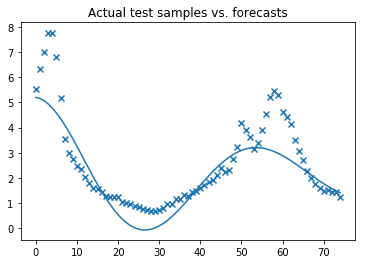

In [22]:
# first test using Auto Arima
data = ili["unweighted_ili"]
train, test = data[:156], data[156:]

arima = pm.auto_arima(train, error_action='ignore', trace=1,
                      seasonal=True)

# Plot actual test vs. forecasts:
x = np.arange(test.shape[0])
plt.scatter(x, test, marker='x')
plt.plot(x, arima.predict(n_periods=test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()

C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:322: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = self.model._index[-1] + 1
C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:323: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  end = self.model._index[-1] + steps
C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Tobi\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting metho

Text(0.5, 1.0, "Holt-Winter's Seasonal Smoothing")

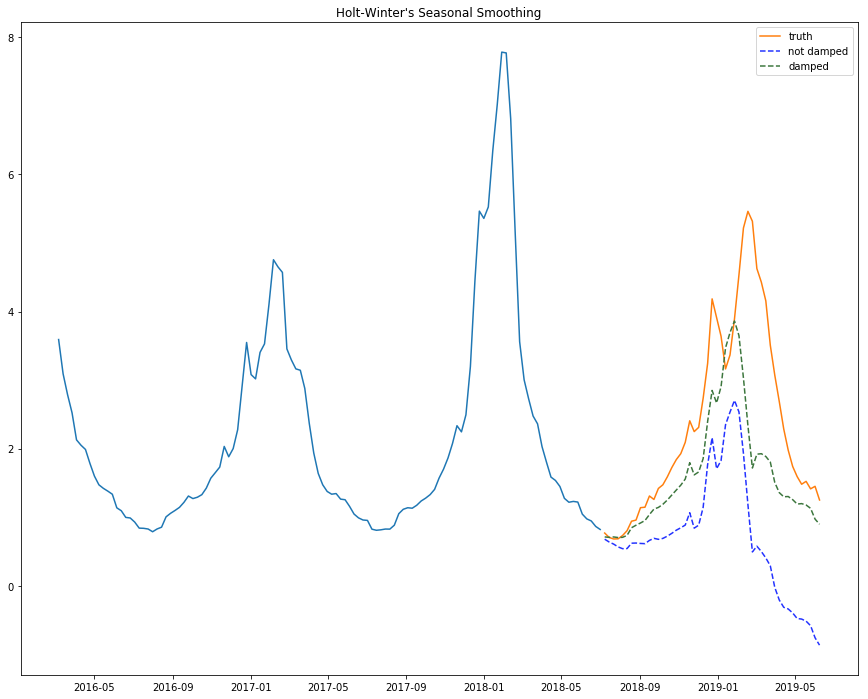

In [23]:
# trying Holt-Winter's exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

data = ili["unweighted_ili"]
train, test = data[:182], data[182:]

model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=52)
model2 = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=52, damped=True)
fit = model.fit()
pred = fit.forecast(49)
fit2 = model2.fit()
pred2 = fit2.forecast(49)

sse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))
sse2 = np.sqrt(np.mean(np.square(test.values - pred2.values)))

fig, ax = plt.subplots(figsize=(15, 12))
ax.plot(train.index[60:], train.values[60:]);
ax.plot(test.index, test.values, label='truth');
ax.plot(test.index, pred, linestyle='--', color='#2332ff', label="not damped");
ax.plot(test.index, pred2, linestyle='--', color='#3c763d', label="damped"); 
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing")

In [24]:
# Seasonal ARIMA - SARIMA
# find best p and q order
res = sm.tsa.arma_order_select_ic(train.dropna(), ic=['aic', 'bic'])
print('ARMA(p,q) =',res['aic_min_order'],'is the best.')

ARMA(p,q) = (4, 1) is the best.


C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [169]:
print(test.head(1)), print(test.tail(1))

date
2018-07-08    0.771497
Freq: W-SUN, Name: unweighted_ili, dtype: float64
date
2019-06-09    1.25311
Freq: W-SUN, Name: unweighted_ili, dtype: float64


(None, None)

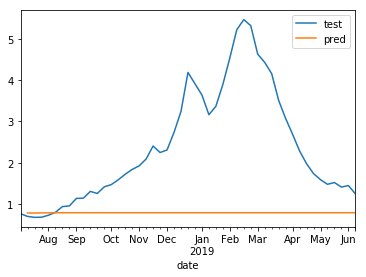

In [25]:
arima = sm.tsa.statespace.SARIMAX(train.dropna(), order=(4,1,1),freq='W',seasonal_order=(0,0,0,0), enforce_stationarity=False, enforce_invertibility=False).fit()
pred_arima = arima.predict("2018-07-08", "2019-06-09")[1:]
pd.DataFrame({'test':test,'pred':pred_arima}).plot()

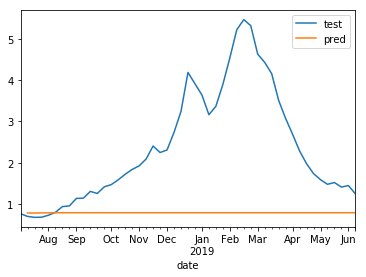

In [26]:
sarima = sm.tsa.statespace.SARIMAX(train,order=(4,1,1),seasonal_order=(0,0,0,1), enforce_stationarity=False, enforce_invertibility=False,freq='W').fit()
pred_sarima = sarima.predict("2018-07-08", "2019-06-09")[1:]
pd.DataFrame({'test':test,'pred':pred_sarima}).plot()

In [27]:
# create dataframes containing additional covariates
ili = add_weekdummies(ili)
train_exog = ili.drop(['unweighted_ili','Unnamed: 0', 'region_type', 'region', 'year', 'weighted_ili', 'age_0_4', 'age_25_49', 'age_25_64', 'age_5_24', 'age_50_64', 'age_65', 'ilitotal', 'num_of_providers', 'total_patients', 'week_start'], axis=1)[:182]
test_exog = ili.drop(['unweighted_ili', 'Unnamed: 0', 'region_type', 'region', 'year', 'weighted_ili', 'age_0_4', 'age_25_49', 'age_25_64', 'age_5_24', 'age_50_64', 'age_65', 'ilitotal', 'num_of_providers', 'total_patients', 'week_start'], axis=1)[182:]

In [28]:
# SARIMAX
sarimax = sm.tsa.statespace.SARIMAX(train,order=(4,1,1),seasonal_order=(0,0,0,1),exog = train_exog, enforce_stationarity=False, enforce_invertibility=False,freq='W').fit()
pred_sarimax = sarimax.predict("2018-07-08", "2019-06-09", exog = train_exog)[1:]
pd.DataFrame({'test':test,'pred':pred_sarimax}).plot()

C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ValueError: Provided exogenous values are not of the appropriate shape. Required (49, 56), got (182, 56).

## To Do 

- getting Google Trends Data for all states -> update the list with the state abbreviations from Google Trends
- getting another list of symptoms from google trends (max. 5 keywords per search) 
- keywords alone or in combination?
- mean correlation over all states